## Libnames

In [92]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('notebook')
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.datasets import load_boston
from sklearn.model_selection import GridSearchCV
from time import time
from sklearn.linear_model import LassoCV, Lasso, RidgeCV, Ridge
from sklearn.model_selection import StratifiedKFold, KFold, LeaveOneOut
from sklearn.linear_model import LinearRegression

## Funções  - data prep

In [93]:
def standard_scaler_manual (data) :
    data2 = (data - data.mean())/data.std()
    return data2


def fit_transform_with_function (data, function, sklearn):
    scaler = function
    
    if sklearn == 'True':
        scaler = function
        data_transformed = scaler.fit_transform(data)
        data_transformed2 = pd.DataFrame(data_transformed, columns = data.columns, index = data.index)
        
    else:
        data_transformed2 = data.apply(function)
        
    return scaler, data_transformed2

#X_train.apply(standard_scaler_manual)


def transform_with_function (data, scaler, sklearn):
    
    if sklearn == 'True':
        data_transformed = scaler.transform(data)
        data_transformed2 = pd.DataFrame(data_transformed, columns = data.columns, index = data.index)
    
    else:
        data_transformed2 = data.apply(scaler)
    
        
    
    return data_transformed2



## Funções Modelagem

In [94]:
def split_train_test_data (data, name_target, test_size, random_state):
    
    X_all = data.drop([name_target], axis = 1)
    y_all = data[name_target]

    X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size = test_size ,random_state = random_state)

    print "Training set has {} samples and {} features.".format(X_train.shape[0], X_train.shape[1])
    print "Testing set has {} samples and {} features.".format(X_test.shape[0], X_test.shape[1])
    
    X_train.reset_index(drop=True, inplace = True)
    X_test.reset_index(drop=True, inplace = True)
    y_train.reset_index(drop=True, inplace = True)
    y_test.reset_index(drop=True, inplace = True)
    
    return X_train, X_test, y_train, y_test

    
def grid_search_model (x, y, clf, parameters, scorer, cv, verbose):
    grid_obj = GridSearchCV(clf, parameters, scoring = scorer, cv =  cv, verbose= verbose)
    start = time()
    grid_fit = grid_obj.fit(x, y)
    end = time()
    print "Best score:" , grid_fit.best_score_
    print "Best parameters:" , grid_fit.best_params_
    print "Find best parameterers in {:.4f} seconds.".format(end - start) 
    return grid_fit.best_estimator_



def model_reg_holdout (reg, X_train, y_train, X_test, y_test, metrics):
    reg.fit(X_train, y_train)
    
    pred_train = reg.predict(X_train)
    pred_test = reg.predict(X_test)

    #coeficientes
    #print "Number of coefficients:", len(reg.coef_)
    #print "Estimated intercept coefficient:", reg.intercept_
   
    #print '\n'
    
    #coefficients = pd.DataFrame(zip(X_train.columns, reg.coef_), columns = ['features', 'coefficients'])
    #coefficients.sort_values(by = 'coefficients', ascending = False, inplace=True)
    #print coefficients
    
        
    first_metric = True
    for metric in metrics:
            name_metric = metric.__name__
            m_tr = metric(y_train, pred_train)
            m_te = metric(y_test, pred_test)
            
            m_tr_te = {
                '1.Treino': [m_tr],
                '2.Teste' : [m_te]
            }
            resultados_aux = pd.DataFrame(m_tr_te, index = [str(name_metric)])
            #print(resultados_aux)
            if first_metric == True:
                results_folds = resultados_aux
                first_metric = False
            else:
                results_folds = pd.concat([results_folds, resultados_aux], axis = 0)    

                #results_folds2 = results_folds
        
            #resultados.index = ['MSE','MAE', 'R2']
       

    #results.index = range(cv.get_n_splits(X))
    #results_mean = np.transpose(pd.DataFrame(results.mean(), columns=['mean']))
    #results = pd.concat([results, results_mean], axis = 0)

    #resultados = pd.DataFrame(resultados)
    #resultados.index = ['MSE','MAE', 'R2']
    return results_folds

def model_reg_cv (model, X, y, cv, metrics):

    first = True

    for train_index, test_index in cv.split(X):
        #print(train_index)
        model2 = model.fit(X.iloc[train_index],y[train_index])
        
        pred_train = model2.predict(X.iloc[train_index])
        pred_test = model2.predict(X.iloc[test_index])

        y_train = y[train_index]
        y_test = y[test_index]
        
        first_metric = True
        for metric in metrics:
            name_metric = metric.__name__
            m_tr = metric(y_train, pred_train)
            m_te = metric(y_test, pred_test)
            
            m_tr_te = {
                str(name_metric) +'- 1.Treino': [m_tr],
                str(name_metric) +'- 2.Teste' : [m_te]
            }
            resultados_aux = pd.DataFrame(m_tr_te)
            
            if first_metric == True:
                results_folds = resultados_aux
                first_metric = False
            else:
                results_folds = pd.concat([results_folds, resultados_aux], axis = 1)    
                
        #results_folds2 = results_folds
        
            #resultados.index = ['MSE','MAE', 'R2']
        if first == True:
            results = results_folds
            first = False
        else:
            results = pd.concat([results, results_folds], axis = 0)    

    results.index = range(cv.get_n_splits(X))
    results_mean = np.transpose(pd.DataFrame(results.mean(), columns=['mean']))
    results = pd.concat([results, results_mean], axis = 0)

    return results

    
    #print(results_folds)
        

def plot_graphs ( X_train, y_train, X_test, y_test):
    plt.scatter(y_train, lm.predict(X_train))
    plt.xlabel("Prices: $Y_i$")
    plt.ylabel("Predicted prices: $\hat{Y}_i$")
    plt.title("Train Data - Prices vs Predicted Prices $Y_i$ vs $\hat{Y}_i$")
    plt.show()

    plt.scatter(y_test, lm.predict(X_test))
    plt.xlabel("Prices: $Y_i$")
    plt.ylabel("Predicted prices: $\hat{Y}_i$")
    plt.title("Test Data - Prices vs Predicted Prices $Y_i$ vs $\hat{Y}_i$")
    plt.show()
    
def plot_residuals(X_train, y_train, X_test, y_test):
    plt.scatter(lm.predict(X_train), lm.predict(X_train)-y_train, c='b', s=40, alpha = 0.5)
    plt.scatter(lm.predict(X_test), lm.predict(X_test)-y_test, c='g', s=40, alpha = 0.5)
    plt.hlines(y=0, xmin = 0, xmax = 50)
    plt.title('Residual Plot using training (blue) and test (green) data')
    plt.ylabel('Residuals')
    plt.show()
    

### Dados

In [95]:
boston = load_boston()

In [96]:
print boston.keys()
print boston.data.shape
print boston.feature_names
#boston.DESCR

['data', 'feature_names', 'DESCR', 'target']
(506L, 13L)
['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


In [97]:
data = pd.DataFrame(boston.data)
data.columns = boston.feature_names

In [98]:
data.head()

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  
0     15.3  396.90   4.98  
1     17.8  396.90   9.14  
2     17.8  392.83   4.03  
3     18.7  394.63   2.94  
4     18.7  396.90   5.33

In [99]:
data['PRICE'] = boston.target

In [100]:
data.head()

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  PRICE  
0     15.3  396.90   4.98   24.0  
1     17.8  396.90   9.14   21.6  
2     17.8  392.83   4.03   34.7  
3     18.7  394.63   2.94   33.4  
4     18.7  396.90   5.33   36.2

In [101]:
X_train, X_test, y_train, y_test = split_train_test_data(data, 'PRICE', test_size = 0.20 ,random_state = 791231)

Training set has 404 samples and 13 features.
Testing set has 102 samples and 13 features.


### data prep - normalização dos dados - usando a biblioteca e usando uma função específica

In [102]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
scaler = MinMaxScaler()


In [103]:
scaler, X_train_final = fit_transform_with_function(X_train,  StandardScaler(), 'True')
X_train_final.head()

CRIM        ZN     INDUS      CHAS       NOX        RM       AGE  \
0 -0.399699 -0.484437 -0.172623 -0.288288 -0.085823 -0.517664  0.861626   
1 -0.397756 -0.484437 -0.382086 -0.288288 -0.318306 -0.166590  0.757293   
2 -0.406474 -0.484437 -1.033588 -0.288288 -0.404410  0.791261  0.196056   
3  0.139224 -0.484437  0.996036 -0.288288  0.491078  0.957122 -0.048586   
4 -0.390968  0.467094 -0.772121 -0.288288 -1.084637 -0.085042  0.368744   

        DIS       RAD       TAX   PTRATIO         B     LSTAT  
0 -0.667972 -0.389419  0.152949 -0.302769  0.405984  0.489518  
1 -0.635883 -0.505355 -0.133371  1.129208  0.379747 -0.047046  
2 -0.401240 -0.505355 -0.658292 -0.857082  0.363262 -0.795192  
3 -0.582764  1.697429  1.548762  0.805859  0.170666 -0.139700  
4  2.038800 -0.273483 -0.455482  0.297738  0.187616 -0.348517

In [104]:
X_test_final = transform_with_function(X_test, scaler, 'True')
X_test_final.head()

CRIM        ZN     INDUS      CHAS       NOX        RM       AGE  \
0 -0.122900 -0.484437  1.209833 -0.288288  2.703967 -1.403642  0.901200   
1 -0.411133 -0.484437 -0.597327 -0.288288 -0.757440  0.184483  0.357951   
2  0.562595 -0.484437  0.996036 -0.288288  1.343514 -0.485874  0.408319   
3 -0.403214  0.056205 -0.481761 -0.288288 -0.283864 -0.550837 -1.077522   
4  1.293269 -0.484437  0.996036 -0.288288  1.231578 -1.945457  1.117061   

        DIS       RAD       TAX   PTRATIO         B     LSTAT  
0 -0.960861 -0.505355 -0.020036 -1.734746 -3.150135  0.479837  
1  0.572744 -0.853162 -0.980403 -0.302769  0.428622 -0.488189  
2 -0.465846  1.697429  1.548762  0.805859 -4.138424  0.590469  
3  0.802403 -0.505355 -0.568817 -1.503782  0.354323  0.420373  
4 -1.030594  1.697429  1.548762  0.805859  0.150234  2.482270

# Modelagem

Objetivos:
Criar funções de:

#### 1. Validação cruzada com grid search (aplicável pra Lasso, Ridge ou outras funcoes que variam ou não parâmetros)
    
##### Nome função: grid_search_model (x, y, clf, parameters, scorer, cv)

X -> base_explicativas

y -> base_resposta

clf -> modelo sklearn

parameters -> parâmetros pra variar tune

scorer -> métrica utilizada para avaliar melhores parâmetros

cv -> objeto de cross-validation (KFold, StratifiedKFold, etc)
 
A função exporta: melhor modelo
Print: melhor score, melhor parâmetro, tempo.


####  2. Validação cruzada sem grid search (aplicável pra qualquer modelo) - exporta métricas (mae, mse,r2) para cada fold e respectivas médias (dentro das partições)

##### Nome função: model_reg_cv (model, X, y, cv):

X -> base_explicativas

y -> base_resposta

model -> modelo sklearn

cv -> objeto de cross-validation (KFold, StratifiedKFold, etc)

A função exporta: treino e teste das partições do cv com mae, mse, r2
Print - coeficientes

#### 3. HoldOut - resultados e fit do modelo em uma base treino específica e aplicação na base teste com  métricas

##### Nome função: model_reg_holdout (reg, X_train, y_train, X_test, y_test)

X_train -> base_explicativas - treino

y_train -> base_resposta - treino

X_test -> base_explicativas - teste

y_test -> base_resposta - teste

reg -> modelo sklearn

A função exporta: treino e teste  com mae, mse, r2


## Regressão Linear

###  CV

In [116]:
cv_kfold = KFold(6, random_state=12)
cv_loo = LeaveOneOut()

In [117]:
lm = LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)
metrics = [mean_squared_error, r2_score]

#model_reg_cv2(lm, X_train_final, y_train, cv = cv_kfold, metrics)
#metrics = [mean_squared_error, mean_absolute_error]
model_reg_cv(lm, X_train_final, y_train, cv_kfold, metrics)

mean_squared_error- 1.Treino  mean_squared_error- 2.Teste  \
0                        21.618668                    26.595164   
1                        21.988410                    25.003380   
2                        23.571535                    16.916424   
3                        22.683992                    21.619024   
4                        22.367153                    22.727495   
5                        20.141830                    34.889752   
mean                     22.061931                    24.625207   

      r2_score- 1.Treino  r2_score- 2.Teste  
0               0.756795           0.632587  
1               0.754127           0.632961  
2               0.736634           0.755275  
3               0.703314           0.839465  
4               0.742734           0.717621  
5               0.764194           0.610848  
mean            0.742966           0.698126

### HoldOut

In [118]:
model_reg_holdout(lm, X_train, y_train, X_test, y_test, metrics)

1.Treino    2.Teste
mean_squared_error  22.271886  20.695189
r2_score             0.741391   0.732702

### Gráficos

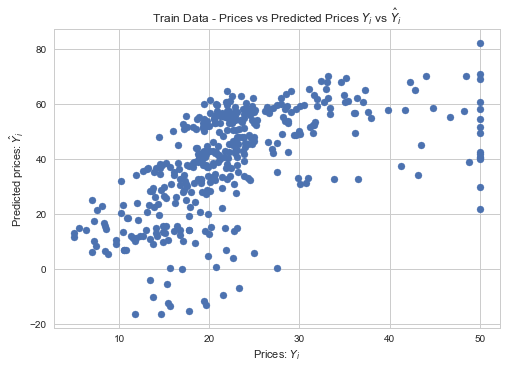

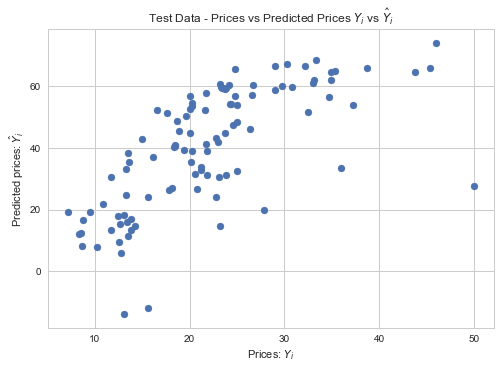

In [119]:
plot_graphs( X_train_final, y_train, X_test_final, y_test)    

### Plot residuals

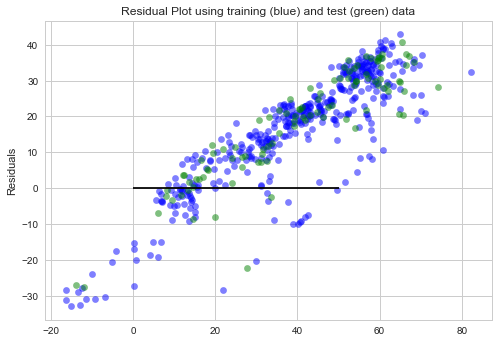

In [120]:
plot_residuals(X_train_final, y_train, X_test_final, y_test)

## Lasso 

### GridSearch + CV

In [121]:
lasso = Lasso(random_state=1)
parameters_lasso = {
    'alpha' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}
model_lasso = grid_search_model(X_train_final, y_train, lasso, parameters_lasso, 'neg_mean_squared_error', cv_kfold, 0 )
model_lasso

Best score: -24.6017818232
Best parameters: {'alpha': 0.01}
Find best parameterers in 0.2390 seconds.


Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=1,
   selection='cyclic', tol=0.0001, warm_start=False)

In [122]:
results_folds = model_reg_cv(model_lasso,X_train_final, y_train, cv_kfold, metrics)
results_folds

mean_squared_error- 1.Treino  mean_squared_error- 2.Teste  \
0                        21.623208                    26.577657   
1                        21.993711                    25.029317   
2                        23.576636                    16.781768   
3                        22.689272                    21.564350   
4                        22.373229                    22.690826   
5                        20.147977                    34.930901   
mean                     22.067339                    24.595803   

      r2_score- 1.Treino  r2_score- 2.Teste  
0               0.756744           0.632828  
1               0.754068           0.632580  
2               0.736577           0.757223  
3               0.703245           0.839871  
4               0.742664           0.718076  
5               0.764122           0.610389  
mean            0.742903           0.698495

In [123]:
model_reg_holdout(model_lasso,X_train_final, y_train, X_test_final, y_test, metrics)

1.Treino    2.Teste
mean_squared_error  22.278490  20.674163
r2_score             0.741314   0.732973

auxiliar -> grid search retorna valores da base de treino caso necessário

In [124]:
parameters_lasso = {
    'alpha' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}
grid_obj = GridSearchCV(lasso, parameters_lasso, scoring = 'neg_mean_squared_error', cv=cv_kfold, return_train_score=True , verbose = 3)
grid_fit = grid_obj.fit(X_train_final, y_train)
cv_results = grid_fit.cv_results_
cv_results = pd.DataFrame(cv_results)

#cv_results2 = cv_results[[ u'param_alpha', u'split0_test_score', u'split0_train_score', u'split1_test_score',
#       u'split1_train_score', u'split2_test_score', u'split2_train_score',
#       u'split3_test_score', u'split3_train_score', u'split4_test_score',
#       u'split4_train_score', u'mean_test_score', u'mean_train_score' ]]
cv_results

Fitting 6 folds for each of 7 candidates, totalling 42 fits
[CV] alpha=0.001 .....................................................
[CV] .................... alpha=0.001, score=-26.593237, total=   0.0s
[CV] alpha=0.001 .....................................................
[CV] .................... alpha=0.001, score=-25.005125, total=   0.0s
[CV] alpha=0.001 .....................................................
[CV] .................... alpha=0.001, score=-16.903692, total=   0.0s
[CV] alpha=0.001 .....................................................
[CV] .................... alpha=0.001, score=-21.612811, total=   0.0s
[CV] alpha=0.001 .....................................................
[CV] .................... alpha=0.001, score=-22.723136, total=   0.0s
[CV] alpha=0.001 .....................................................
[CV] .................... alpha=0.001, score=-34.892754, total=   0.0s
[CV] alpha=0.01 ......................................................
[CV] ............

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] alpha=100 .......................................................
[CV] ...................... alpha=100, score=-72.451156, total=   0.0s
[CV] alpha=100 .......................................................
[CV] ...................... alpha=100, score=-70.109634, total=   0.0s
[CV] alpha=100 .......................................................
[CV] ...................... alpha=100, score=-69.124870, total=   0.0s
[CV] alpha=100 .......................................................
[CV] ..................... alpha=100, score=-134.741722, total=   0.0s
[CV] alpha=100 .......................................................
[CV] ...................... alpha=100, score=-82.297017, total=   0.0s
[CV] alpha=100 .......................................................
[CV] ...................... alpha=100, score=-89.668707, total=   0.0s
[CV] alpha=1000 ......................................................
[CV] ..................... alpha=1000, score=-72.451156, total=   0.0s
[CV] a

[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed:    0.2s finished


mean_fit_time  mean_score_time  mean_test_score  mean_train_score  \
0       0.001500         0.000667       -24.627621        -22.061988   
1       0.003833         0.000500       -24.601782        -22.067339   
2       0.003167         0.000833       -24.945068        -22.512182   
3       0.001000         0.000000       -30.503457        -28.925076   
4       0.001333         0.000333       -86.324007        -86.106333   
5       0.001833         0.000500       -86.324007        -86.106333   
6       0.001333         0.000333       -86.324007        -86.106333   

  param_alpha             params  rank_test_score  split0_test_score  \
0       0.001  {u'alpha': 0.001}                2         -26.593237   
1        0.01   {u'alpha': 0.01}                1         -26.577657   
2         0.1    {u'alpha': 0.1}                3         -26.753513   
3           1      {u'alpha': 1}                4         -29.522174   
4          10     {u'alpha': 10}                5         -72.451156   
5         100    {u'alpha': 100}                5         -72.451156   
6        1000   {u'alpha': 1000}                5         -72.451156   

   split0_train_score  split1_test_score       ...         split3_test_score  \
0          -21.618713         -25.005125       ...                -21.612811   
1          -21.623208         -25.029317       ...                -21.564350   
2          -22.057508         -26.118863       ...                -21.612191   
3          -28.416694         -31.857470       ...                -32.312944   
4          -88.890612         -70.109634       ...               -134.741722   
5          -88.890612         -70.109634       ...               -134.741722   
6          -88.890612         -70.109634       ...               -134.741722   

   split3_train_score  split4_test_score  split4_train_score  \
0          -22.684045         -22.723136          -22.367214   
1          -22.689272         -22.690826          -22.373229   
2          -23.130311         -23.145877          -22.797407   
3          -30.161958         -29.306925          -29.248229   
4          -76.457801         -82.297017          -86.941814   
5          -76.457801         -82.297017          -86.941814   
6          -76.457801         -82.297017          -86.941814   

   split5_test_score  split5_train_score  std_fit_time  std_score_time  \
0         -34.892754          -20.141891  7.637073e-04        0.000471   
1         -34.930901          -20.147977  2.608788e-03        0.000500   
2         -36.125173          -20.619885  2.266832e-03        0.000687   
3         -42.691569          -25.964227  1.123916e-07        0.000000   
4         -89.668707          -85.416925  4.713704e-04        0.000471   
5         -89.668707          -85.416925  6.872308e-04        0.000500   
6         -89.668707          -85.416925  4.713142e-04        0.000471   

   std_test_score  std_train_score  
0        5.491115         1.052594  
1        5.537053         1.052376  
2        6.127650         1.036185  
3        7.395459         1.694777  
4       22.782135         4.556848  
5       22.782135         4.556848  
6       22.782135         4.556848  

[7 rows x 23 columns]

## KNN

In [125]:
from sklearn.neighbors import KNeighborsRegressor

In [126]:
knn = KNeighborsRegressor()
#cv = KFold(5, random_state=1, shuffle=True)

parameters_knn = {
    'n_neighbors' : [1, 2,3,4,5]
}
model_knn = grid_search_model(X_train_final, y_train, knn, parameters_knn, 'neg_mean_squared_error', cv_loo, 0 )
model_knn

Best score: -17.5085726073
Best parameters: {'n_neighbors': 3}
Find best parameterers in 17.5160 seconds.


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=3, p=2,
          weights='uniform')

In [129]:
results_folds = model_reg_cv(model_knn,X_train_final, y_train, cv_loo, metrics=metrics)
results_folds

mean_squared_error- 1.Treino  mean_squared_error- 2.Teste  \
0                         8.398462                     0.004444   
1                         8.397497                     0.160000   
2                         8.351839                     2.151111   
3                         8.373248                    43.560000   
4                         8.401963                     0.160000   
5                         8.384160                     6.250000   
6                         8.205109                   182.250000   
7                         8.349043                    22.404444   
8                         8.387786                     0.751111   
9                         8.390915                     5.290000   
10                        8.365131                    17.640000   
11                        8.389404                     2.454444   
12                        8.370094                     2.351111   
13                        8.394114                     1.604444   
14                        8.365109                    32.871111   
15                        8.362062                    17.084444   
16                        8.387386                     0.321111   
17                        8.405487                     4.987778   
18                        8.395175                     0.751111   
19                        8.307204                    36.401111   
20                        8.187667                    27.040000   
21                        8.395702                     1.521111   
22                        8.395853                     4.987778   
23                        8.384431                     7.840000   
24                        8.400207                     1.521111   
25                        8.361674                     3.484444   
26                        8.392796                     1.137778   
27                        8.382520                     4.134444   
28                        8.399859                     2.250000   
29                        8.402845                    17.640000   
...                            ...                          ...   
375                       8.391337                     5.444444   
376                       8.378307                     9.201111   
377                       8.395192                     0.027778   
378                       8.393750                    12.960000   
379                       8.404544                     2.890000   
380                       8.347761                   131.484444   
381                       8.373907                     8.027778   
382                       8.371326                    24.010000   
383                       8.487601                     9.404444   
384                       8.480000                    12.484444   
385                       7.961883                    88.987778   
386                       8.371558                    14.440000   
387                       8.395073                    13.937778   
388                       8.369506                    11.787778   
389                       8.398404                     0.217778   
390                       8.415255                     0.360000   
391                       8.367455                     0.321111   
392                       8.434216                     0.090000   
393                       8.289090                    47.151111   
394                       8.419363                     6.250000   
395                       8.393394                     0.111111   
396                       8.397243                     0.250000   
397                       8.468859                     2.454444   
398                       8.396223                     0.160000   
399                       8.297510                     3.484444   
400                       8.347020                    25.671111   
401                       8.388605                    10.454444   
402                       8.390102                   

In [128]:
model_reg_holdout(model_knn,X_train_final, y_train, X_test_final, y_test, metrics=metrics)

1.Treino    2.Teste
mean_squared_error  8.376482  20.941089
r2_score            0.902737   0.729526

## Ridge

In [131]:
ridge = Ridge(random_state=11)
parameters_ridge = {
    'alpha' : [0.001,0.05, 0.01,0.1, 1,10]
}
model_ridge = grid_search_model(X_train_final, y_train, ridge, parameters_ridge, 'neg_mean_squared_error', cv_kfold, 0)
model_ridge

Best score: -24.6223753764
Best parameters: {'alpha': 1}
Find best parameterers in 0.5110 seconds.


Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=11, solver='auto', tol=0.001)

In [132]:
results_folds = model_reg_cv(model_ridge,X_train_final, y_train, cv_kfold, metrics = metrics)
results_folds

mean_squared_error- 1.Treino  mean_squared_error- 2.Teste  \
0                        21.620465                    26.594487   
1                        21.990514                    25.020366   
2                        23.573887                    16.818427   
3                        22.686332                    21.594088   
4                        22.369244                    22.720496   
5                        20.143478                    34.951014   
mean                     22.063987                    24.616480   

      r2_score- 1.Treino  r2_score- 2.Teste  
0               0.756774           0.632596  
1               0.754103           0.632712  
2               0.736607           0.756693  
3               0.703283           0.839651  
4               0.742710           0.717708  
5               0.764175           0.610165  
mean            0.742942           0.698254

In [133]:
model_reg_holdout(model_ridge, X_train_final, y_train, X_test_final, y_test, metrics = metrics)

1.Treino    2.Teste
mean_squared_error  22.273312  20.685154
r2_score             0.741374   0.732831